In [1]:
import sys; sys.path.append('..')
import pyzx as zx
import random
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

Available backends: simple, igraph


In [2]:
tree = zx.Graph()
ty = [0,0,0,   1,1,1,   1,   1,   1,1,   0,0]
q  = [0,1,2,   0,1,2,   1,   1,   0,1,   0,1]
r  = [0,0,0,   1,1,1,   2,   3,   4,4,   5,5]
tree.add_vertices(len(ty))
for i,t in enumerate(ty):
    tree.set_type(i, t)
    tree.set_vdata(i, 'q', q[i])
    tree.set_vdata(i, 'r', r[i])
tree.add_edges([(0,3), (1,4), (2,5)])
tree.add_edges([(3,6), (4,6), (5,6), (6,7), (7,8), (7,9), (3,8), (5,7)], edgetype=2)
tree.add_edges([(8,10), (9,11)])
tree.set_angle(6, 1/2)

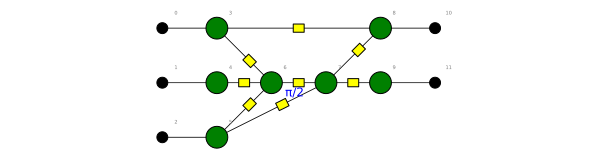

In [3]:
zx.draw(tree, labels=True)

In [4]:
zx.rules.match_lc(tree)

[[6, [3, 4, 5, 7]]]

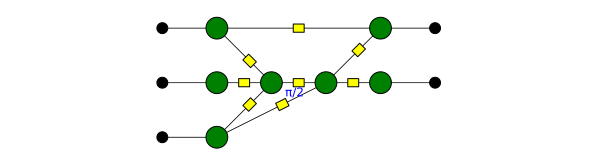

In [5]:
tree1 = tree.copy()
zx.rules.pivot(tree1, zx.rules.match_pivot_parallel(tree1))
zx.draw(tree1)

In [12]:
random.seed(1330)
g = zx.cnots(5, 50)
g.set_angle(40, 1)
g.set_angle(45, 1)
zx.spider_simp(g)
zx.simplify.to_gh(g)

spider_simp
18. 12. 9. 7. 3. 1. 1. 
finished in 8 iterations


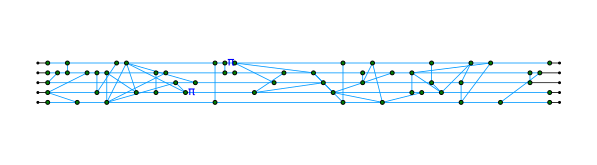

In [13]:
zx.draw(g, h_edge_draw='blue')

In [14]:
while True:
    m = zx.rules.match_pivot_parallel(g)
    if len(m) > 0: zx.rules.pivot(g, m)
    else: break

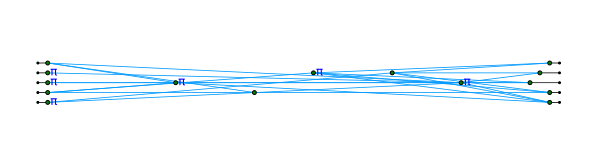

In [15]:
zx.draw(g, h_edge_draw='blue')

In [16]:
zx.simplify.to_rg(g)
zx.drawing.pack_circuit_nf(g, 'grg')

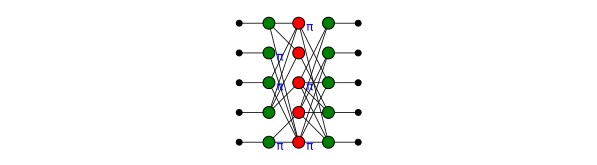

In [17]:
zx.draw(g)

In [29]:
def simp(g):
    zx.spider_simp(g)
    print('convert to gh-form...', end='', flush=True)
    zx.simplify.to_gh(g)
    print('done.')
    print('pivot_simp')
    i = 0
    while True:
        i += 1
        m = zx.rules.match_pivot_parallel(g)
        if len(m) > 0:
            print(len(m), end='', flush=True)
            zx.rules.pivot(g, m)
            print('. ', end='', flush=True)
        else: break
    print('\nfinished in ' + str(i) + ' iterations')
    print('converting to rg-form...', end='', flush=True)
    zx.simplify.to_rg(g)
    print('done.')

%time g = zx.cnots(5,10**5)
%time simp(g)

Wall time: 1.55 s
spider_simp
32322. 24505. 17609. 11911. 7269. 3845. 1580. 491. 127. 29. 3. 
finished in 12 iterations
convert to gh-form...done.
pivot_simp
18709. 9822. 6011. 4064. 2887. 2128. 1527. 1122. 877. 667. 540. 424. 319. 245. 181. 144. 119. 87. 65. 49. 37. 26. 26. 18. 13. 10. 8. 6. 6. 4. 3. 3. 3. 2. 
finished in 35 iterations
converting to rg-form...done.
Wall time: 24.3 s


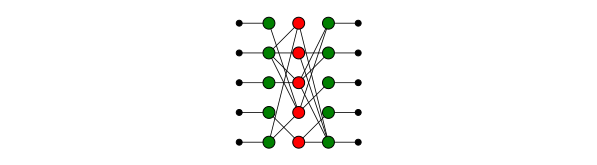

In [30]:
zx.drawing.pack_circuit_nf(g, 'grg')
zx.draw(g)